In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import seaborn as sns
import scipy

In [2]:
#DATA_DIR = '../input/vggface-using-tripletloss/images_resolute/VGG_ResoluteAI'
#DATA_DIR = "../input/vggface-using-tripletloss/dataset/dataset"
#DATA_DIR = "../input/vggface-using-tripletloss/crop_faces/faces"
DATA_DIR = "../input/vggface-using-tripletloss/celebs/celebs"

DATA_DIR = pathlib.Path(DATA_DIR)
image_count = int(len(list(DATA_DIR.glob('*/*.jpg'))))
print("Number of images: ",image_count)
num_classes = len(os.listdir(DATA_DIR))
print("Number of classes: ",num_classes)

Number of images:  10029
Number of classes:  100


In [3]:
BATCH_SIZE = 32
HEIGHT = 224
WIDTH = 224
TYPES = [
         ["sparse_categorical","max","val_sparse_categorical_accuracy",0.5,"cosine"],
         ["triplet","min","val_loss",10000,"euclidian"],
         ["triplet","min","val_loss",10000,"cosine"]
        ]

ID = 2
LOSS_TYPE = TYPES[ID][0]
MODE = TYPES[ID][1]
MONITOR = TYPES[ID][2]
THRESHOLD = TYPES[ID][3]
DIST_TYPE = TYPES[ID][4]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.1,
  subset = "training",
  seed=123,
  image_size=(HEIGHT,WIDTH),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(HEIGHT,WIDTH),
  batch_size= BATCH_SIZE)

class_names = train_ds.class_names

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10029 files belonging to 100 classes.
Using 9027 files for training.
Found 10029 files belonging to 100 classes.
Using 1002 files for validation.


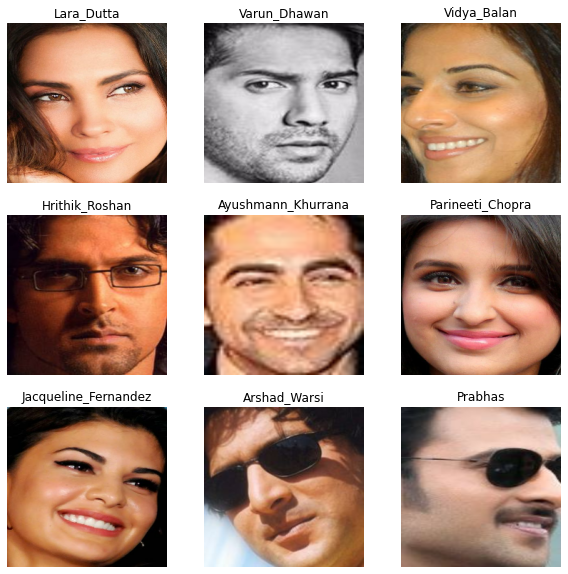

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy()),cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
class NormalizeLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(NormalizeLayer, self).__init__()

    def call(self, inputs, mask=None):
        return tf.math.l2_normalize(inputs, axis=-1)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}
    
norm_layer = NormalizeLayer()

pretrained_model = tf.keras.applications.VGG16(weights = 'imagenet',include_top = False,input_shape = (HEIGHT,WIDTH, 3))

for layer in pretrained_model.layers:
    layer.trainable = False
    
def create_model(loss_type=LOSS_TYPE,dist_type = DIST_TYPE):
    top_model = pretrained_model.output
    top_model = tf.keras.layers.Flatten(name = "flatten") (top_model)
    top_model = tf.keras.layers.Dense(512) (top_model)
    top_model = tf.keras.layers.LeakyReLU(alpha=0.2) (top_model)
    top_model = tf.keras.layers.Dropout(0.3) (top_model)
    top_model = tf.keras.layers.Dense(256) (top_model)
    top_model = tf.keras.layers.LeakyReLU(alpha=0.2) (top_model)
    top_model = tf.keras.layers.GaussianDropout(0.5) (top_model)
    top_model = tf.keras.layers.Dense(128, activation=None) (top_model)
    
    if loss_type == "sparse_categorical":
        top_model = tf.keras.layers.Dense(num_classes, activation="softmax")(top_model)
    
    elif loss_type == "triplet" and dist_type == "euclidian":
        top_model = norm_layer(top_model)
        
    model = tf.keras.Model(inputs = pretrained_model.input, outputs = top_model)
    
    return model

model = create_model(LOSS_TYPE,DIST_TYPE)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [6]:
def pairwise_distances(embeddings):
    dot_product = tf.linalg.matmul(embeddings, tf.transpose(embeddings))
    square_norm = tf.linalg.diag_part(dot_product)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)
    distances = tf.math.maximum(distances, 0.0)

    mask = tf.cast(tf.equal(distances, 0.0),tf.float32)
    distances = distances + mask * 1e-16
    distances = tf.math.sqrt(distances)
    distances = distances * (1.0 - mask)

    return distances

def get_anchor_positive_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.math.logical_not(indices_equal)

    labels_equal = tf.math.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.math.logical_and(indices_not_equal, labels_equal)

    return mask

def get_anchor_negative_triplet_mask(labels):
    labels_equal = tf.math.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.math.logical_not(labels_equal)

    return mask

def get_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.math.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.math.logical_and(tf.math.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    label_equal = tf.math.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.math.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    mask = tf.math.logical_and(distinct_indices, valid_labels)

    return mask


class TripletLossFn(tf.keras.losses.Loss):
    def __init__(self,margin=1.0,**kwargs):
        super().__init__(**kwargs)
        self.margin = margin
  
    def call(self,y_true,y_pred):

        labels = tf.convert_to_tensor(y_true)
        labels = tf.squeeze(labels,axis=-1)
        embeddings = tf.convert_to_tensor(y_pred)

        pairwise_dist = pairwise_distances(embeddings)

        mask_anchor_positive = get_anchor_positive_triplet_mask(labels)
        mask_anchor_positive = tf.cast(mask_anchor_positive,tf.float32)

        anchor_positive_dist = tf.math.multiply(mask_anchor_positive, pairwise_dist)

        hardest_positive_dist = tf.math.reduce_max(anchor_positive_dist, axis=1, keepdims=True)


        mask_anchor_negative = get_anchor_negative_triplet_mask(labels)
        mask_anchor_negative = tf.cast(mask_anchor_negative,tf.float32)

        max_anchor_negative_dist = tf.math.reduce_max(pairwise_dist, axis=1, keepdims=True)
        anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)


        hardest_negative_dist = tf.math.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    

        triplet_loss = tf.math.maximum(hardest_positive_dist - hardest_negative_dist + self.margin, 0.0)

        triplet_loss = tf.math.reduce_mean(triplet_loss)

        return triplet_loss
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,"margin":self.margin}

In [7]:
def create_callbacks(model_save_path,monitor = MONITOR,mode = MODE):
    
    
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    
    cpk_path = f'{model_save_path}/best_model.h5'

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor=monitor,
        mode=mode,
        save_best_only=True,
        verbose=1
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= monitor,     
        mode=mode,
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,       
        mode=mode,
        patience=15, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr]         #, earlystop
    
    return callbacks

In [8]:
def compile_model(model, lr=0.0001,loss = LOSS_TYPE):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    if loss == "triplet":
        loss = TripletLossFn(0.85)
        model.compile(optimizer=optimizer, loss=loss)
    elif loss == "sparse_categorical":
        loss = tf.keras.losses.SparseCategoricalCrossentropy(name='sparse_categorical_crossentropy')
        metric = tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy')
        model.compile(optimizer=optimizer,loss=loss,metrics=[metric])
    else:
        print("Wrong Input")
    return model

In [9]:
EPOCHS = 60
VERBOSE  = 1
MODEL_PATH = '.'

with tf.device("/device:GPU:0"):
    model = create_model(LOSS_TYPE,DIST_TYPE)
    model = compile_model(model, lr=0.0001)
   
    callbacks = create_callbacks(MODEL_PATH)
    
    history = model.fit(train_ds, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE)

Epoch 1/60
283/283 [==============================] - ETA: 0s - loss: 0.6418
Epoch 00001: val_loss improved from inf to 0.40972, saving model to ./best_model.h5
283/283 [==============================] - 96s 338ms/step - loss: 0.6418 - val_loss: 0.4097
Epoch 2/60
282/283 [============================>.] - ETA: 0s - loss: 0.4398
Epoch 00002: val_loss did not improve from 0.40972
283/283 [==============================] - 20s 70ms/step - loss: 0.4396 - val_loss: 0.5038
Epoch 3/60
282/283 [============================>.] - ETA: 0s - loss: 0.4014
Epoch 00003: val_loss did not improve from 0.40972
283/283 [==============================] - 20s 69ms/step - loss: 0.4013 - val_loss: 0.5445
Epoch 4/60
282/283 [============================>.] - ETA: 0s - loss: 0.3868
Epoch 00004: val_loss did not improve from 0.40972
283/283 [==============================] - 20s 70ms/step - loss: 0.3866 - val_loss: 0.5566
Epoch 5/60
282/283 [============================>.] - ETA: 0s - loss: 0.3508
Epoch 00005: 

In [10]:
model = tf.keras.models.load_model("./best_model.h5",custom_objects={'TripletLossFn': TripletLossFn,'NormalizeLayer':NormalizeLayer})

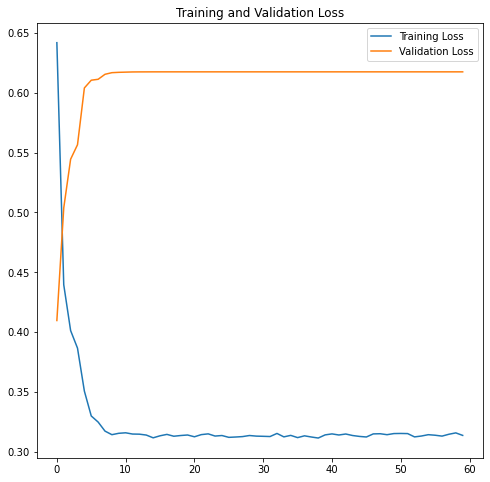

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(8, 8))

if LOSS_TYPE == "sparse_categorical":
    acc=history.history['sparse_categorical_accuracy']
    val_acc=history.history['val_sparse_categorical_accuracy']
    
    plt.subplot(1,2,1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.subplot(1,2,2)
    plt.plot(epochs_range, acc, 'r', label="Training Accuracy")
    plt.plot(epochs_range, val_acc, 'b', label="Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.legend(loc='lower right')
elif LOSS_TYPE == "triplet":
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
else:
    print("Wrong Input")

In [12]:
def img_arr(filepath):
    im = tf.keras.preprocessing.image.load_img(filepath,target_size = (HEIGHT,WIDTH))
    im = tf.keras.preprocessing.image.img_to_array(im)
    arr = np.asarray(im)/255.
    return arr

cosine_loss = tf.keras.losses.CosineSimilarity(axis=-1)

def find_dist(filepath1,filepath2,loss_type=LOSS_TYPE,dist_type=DIST_TYPE):
    
    face1 = img_arr(filepath1)
    face2 = img_arr(filepath2)
    arr = np.array([face1,face2])
    
    if loss_type == "sparse_categorical":
        model1= tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
        embed = model1(arr,training=False)
    elif loss_type == "triplet":
        embed = model(arr,training=False)
    
    encod1 = tf.expand_dims(embed[0],axis=1)
    encod2 = tf.expand_dims(embed[1],axis=1)
    
    if dist_type == "cosine":
        #dist = np.abs(cosine_loss(encod1,encod2).numpy())
        dist = scipy.spatial.distance.cosine(embed[0],embed[1])
        dist = round(dist,2)
    elif dist_type == "euclidian":
        dist = 1e+4*np.array(tf.norm(embed[0]-embed[1], ord='euclidean'))
        dist = round(dist,2)
    return dist

def display_result(filepath1,filepath2):
    if filepath2 == None:
        plt.imshow(img_arr(filepath1))
        plt.axis("off")
        plt.title("No matches Found")
        plt.show()
    else:
        plt.subplot(1,2,1)
        plt.imshow(img_arr(filepath1))
        plt.axis("off")
        plt.title("Given Image")
        plt.subplot(1,2,2)
        plt.imshow(img_arr(filepath2))
        plt.axis("off")
        plt.title("Match Found")
        plt.show()

# TESTING

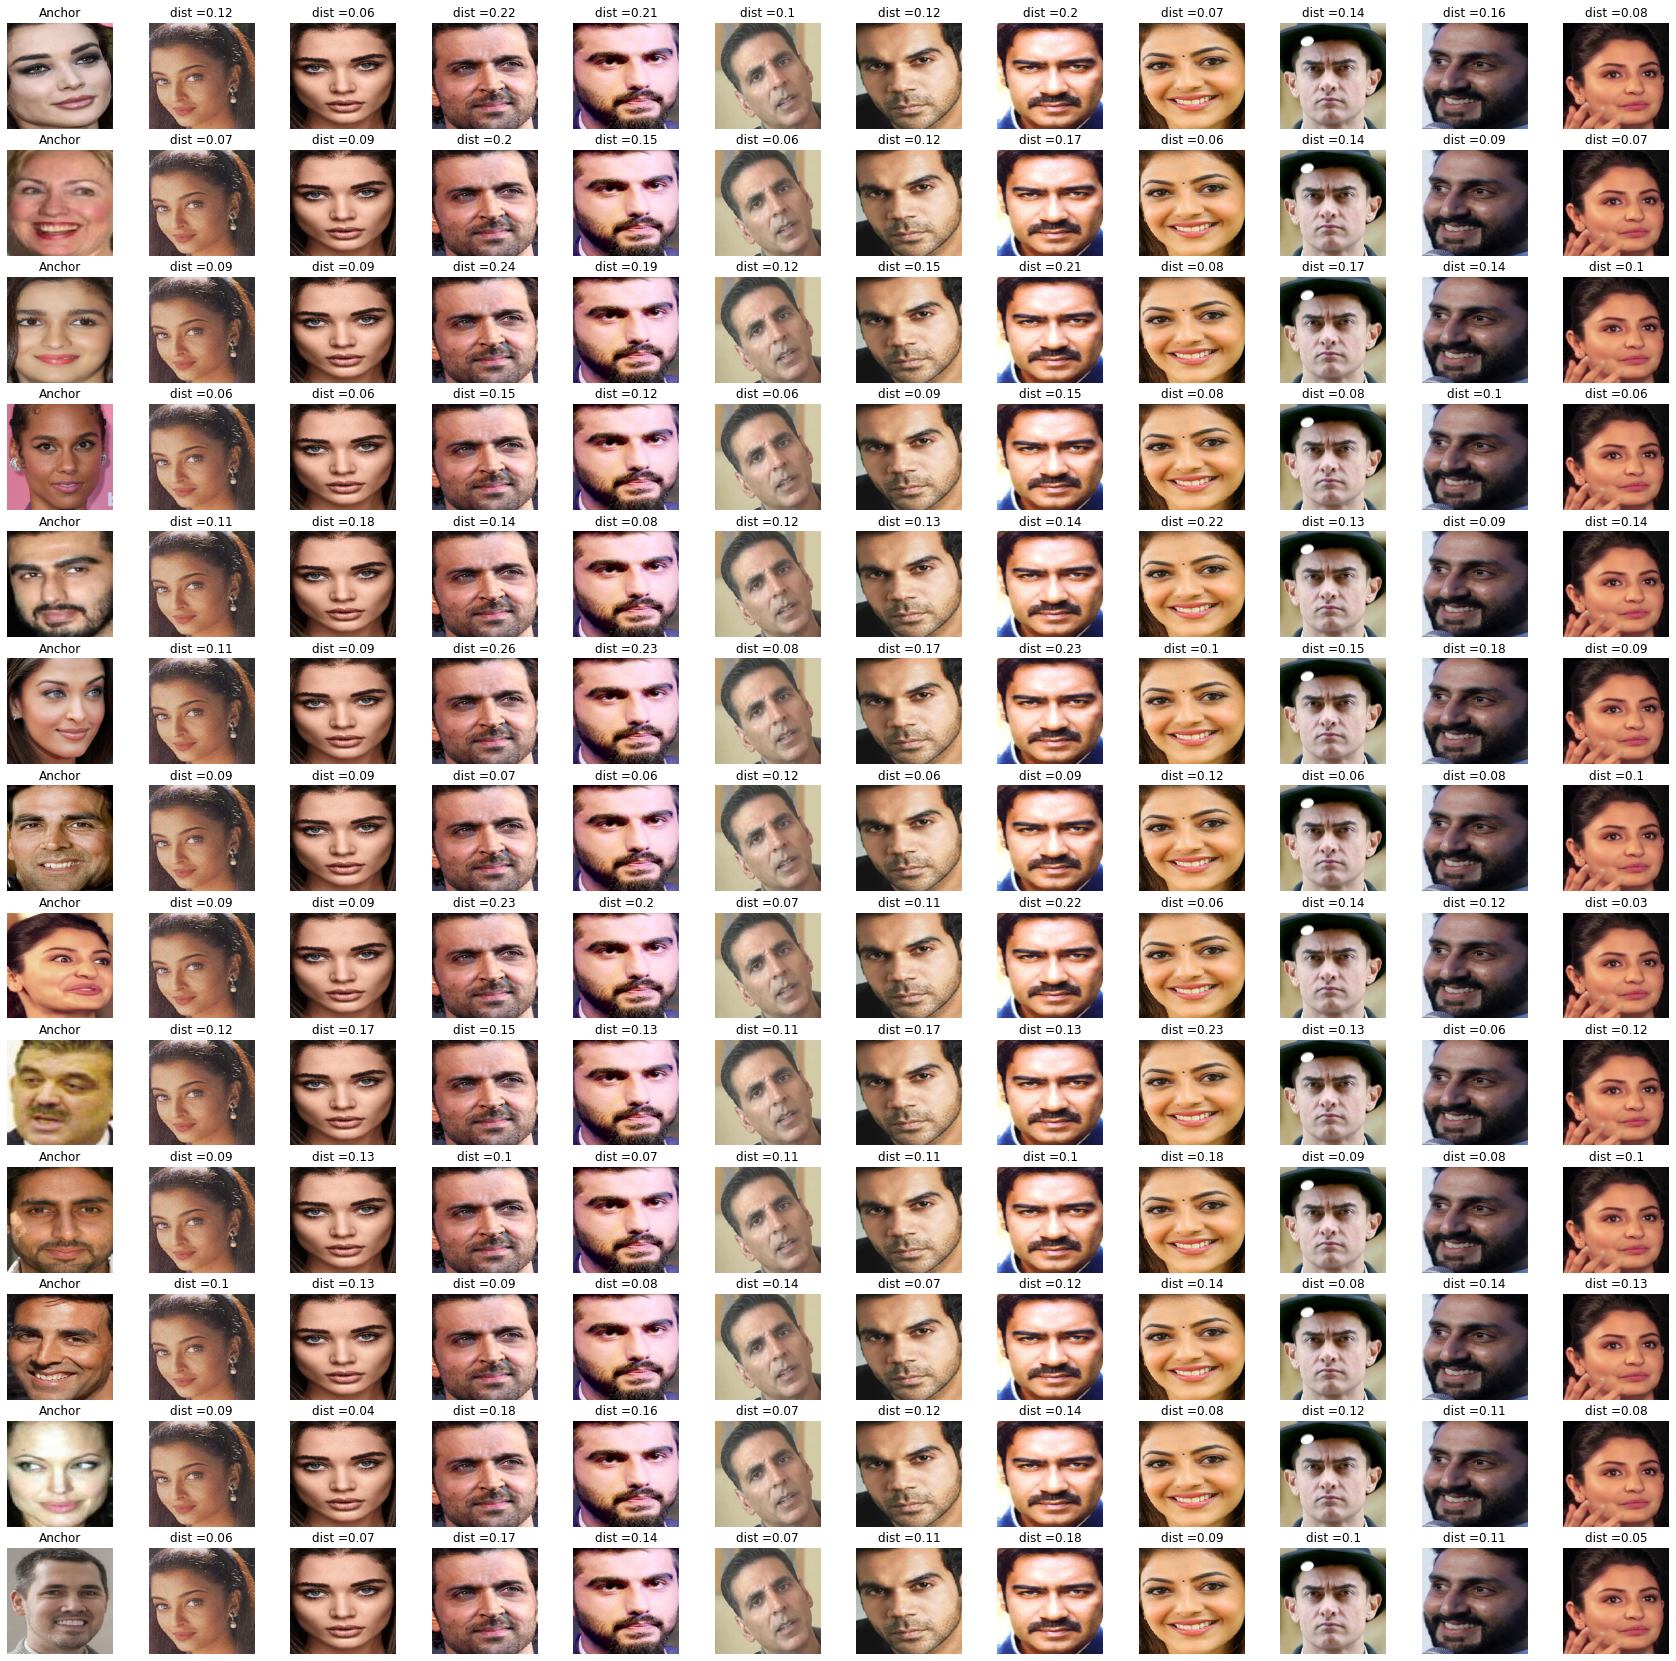

In [13]:
known_path = "../input/vggface-using-tripletloss/known"
unknown_path = "../input/vggface-using-tripletloss/un_known"

known_ls = os.listdir(known_path)
unknown_ls = os.listdir(unknown_path)

known_count = len(known_ls)
unknown_count = len(unknown_ls)


dist_dict = {}
plt.figure(figsize=(30,30))

for i,img_i in enumerate(unknown_ls):
    path1 = os.path.join(unknown_path,img_i)
    
    plt.subplot(unknown_count,known_count+1,(known_count+1)*i+1)
    plt.imshow(img_arr(path1))
    plt.title("Anchor")
    plt.axis("off")
    j = 2
    dist_dict[img_i] = {}
    for img_j in known_ls:
        path2 = os.path.join(known_path,img_j)
        dist = find_dist(path1,path2,LOSS_TYPE,DIST_TYPE)
        dist_dict[img_i][img_j] = dist
        plt.subplot(unknown_count,known_count+1,(known_count+1)*i+j)
        plt.imshow(img_arr(path2))
        text = "dist ="+str(dist)
        plt.title(text)
        plt.axis("off")
        j = j+1

Match found for 76.jpg is 35.jpg


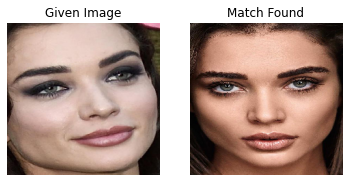

Match found for 5.jpg is 2_2.jpg


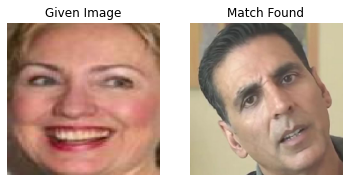

Match found for 2_3.jpg is 6_1.jpg


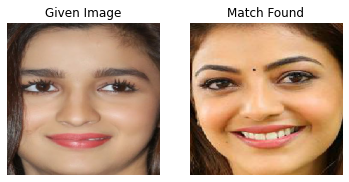

Match found for 0_3.jpg is 3_2.jpg


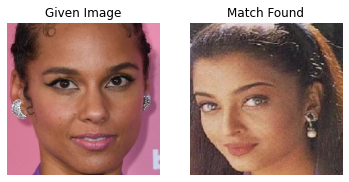

Match found for 0_5.jpg is 46.jpg


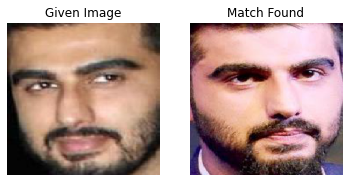

Match found for 0_2.jpg is 2_2.jpg


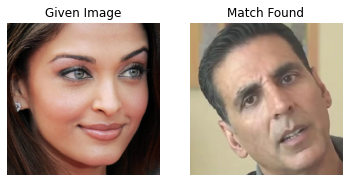

Match found for 0_4.jpg is 46.jpg


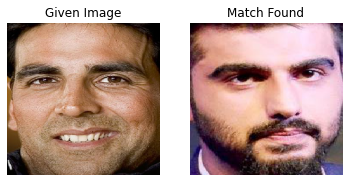

Match found for 4_1.jpg is 4_2.jpg


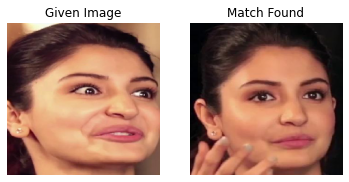

Match found for 1.jpg is 11.jpg


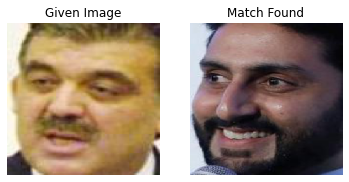

Match found for 15.jpg is 46.jpg


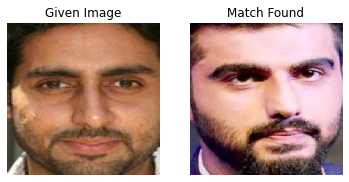

Match found for 11.jpg is 7_1.jpg


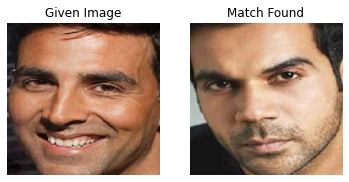

Match found for 4.jpg is 35.jpg


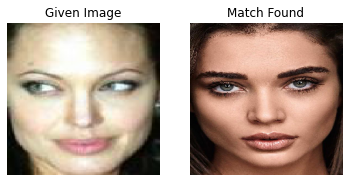

Match found for 0_1.jpg is 4_2.jpg


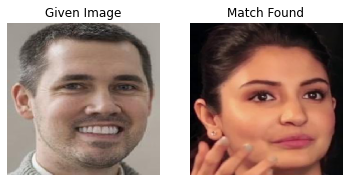

In [14]:
for i,label_dict in enumerate(dist_dict.values()):
    label = list(label_dict.values())
    
    if LOSS_TYPE == "sparse_categorical":
        req_id = np.argmax(label)
    elif LOSS_TYPE == "triplet":
        req_id = np.argmin(label)
    given_img = list(dist_dict.keys())[i]
    filepath1 = os.path.join(unknown_path,given_img)
    
    if LOSS_TYPE == "sparse_categorical":
        if label[req_id] > THRESHOLD:
            found_img = list(label_dict.keys())[req_id]
            print("Match found for {} is {}".format(given_img,found_img))
            filepath2 = os.path.join(known_path,found_img)
            display_result(filepath1,filepath2)
        else:
            print("No match found for {}".format(given_img))
            display_result(filepath1,None)
    elif LOSS_TYPE == "triplet":
        if label[req_id] < THRESHOLD:
            found_img = list(label_dict.keys())[req_id]
            print("Match found for {} is {}".format(given_img,found_img))
            filepath2 = os.path.join(known_path,found_img)
            display_result(filepath1,filepath2)
        else:
            print("No match found for {}".format(given_img))
            display_result(filepath1,None)

In [15]:
'''import cv2
import sklearn.metrics
from datetime import datetime

def get_known_embeddings(folder_path):
    st = datetime.now()
    known_images_folder =  folder_path
    known_images_numpy_array = [cv2.imread(os.path.join(known_images_folder, x)) for x in os.listdir(known_images_folder)]
    try:
        known_images_resized_array = [cv2.resize(target_image,target_size) for target_image in known_images_numpy_array]
    except:
        pass
    print("number of images and array", len(os.listdir(known_images_folder)), len(known_images_numpy_array))
    print("*"*20)
    print("creating embeddings")
    known_embeddings = model.predict(np.array(known_images_resized_array))
    print("Embeddings created of shape",known_embeddings.shape )
    print("*"*20)
    print("finished process in ", datetime.now()-st)
    return known_embeddings, known_images_resized_array

def show_image(array, title):
    plt.figure(figsize=(2, 2))
    plt.imshow(array)
    plt.title(title)
    plt.show()

def show_comparision(test_image_array, similar_image_array):

    plt.figure(figsize=(4, 4))
 
    ax = plt.subplot(1, 2, 1)
    plt.imshow(test_image_array)
    plt.title('Test Image')
    plt.axis("off")

    ax = plt.subplot(1, 2, 2)
    plt.imshow(similar_image_array)
    plt.title('Similar Image')
    plt.axis("off")
  
    plt.show()


def prepare_test_image(path):
    image_array = cv2.imread(path)
    resized_array = cv2.resize(image_array, target_size)
    test_image = np.expand_dims(resized_array,0)
    return resized_array, test_image


folder_path = "../input/vggface-using-tripletloss/known"
def test(known_folder_path, unknown_folder_path, target_size):

    known_embeddings,known_images_resized_array = get_known_embeddings(known_folder_path)

    for test_image_name in os.listdir(unknown_folder_path):
        test_image_path = os.path.join(unknown_folder_path,test_image_name)
        test_image_to_show, test_image_expanded = prepare_test_image(test_image_path)
        test_image_embedding = model.predict(test_image_expanded)
        
        min_distance = sklearn.metrics.pairwise_distances(test_image_embedding, known_embeddings, metric='l2')
        argmin = sklearn.metrics.pairwise_distances_argmin_min(test_image_embedding, known_embeddings, axis=1, metric='l2', metric_kwargs=None)
    

        similar_image = known_images_resized_array[argmin[0][0]]
        show_comparision(test_image_to_show, similar_image)
        print("*"*20)
        
target_size = (HEIGHT,WIDTH)
known_folder_path = "../input/vggface-using-tripletloss/known"
unknown_folder_path = "../input/vggface-using-tripletloss/un_known"
test(known_folder_path, unknown_folder_path, target_size)'''

'import cv2\nimport sklearn.metrics\nfrom datetime import datetime\n\ndef get_known_embeddings(folder_path):\n    st = datetime.now()\n    known_images_folder =  folder_path\n    known_images_numpy_array = [cv2.imread(os.path.join(known_images_folder, x)) for x in os.listdir(known_images_folder)]\n    try:\n        known_images_resized_array = [cv2.resize(target_image,target_size) for target_image in known_images_numpy_array]\n    except:\n        pass\n    print("number of images and array", len(os.listdir(known_images_folder)), len(known_images_numpy_array))\n    print("*"*20)\n    print("creating embeddings")\n    known_embeddings = model.predict(np.array(known_images_resized_array))\n    print("Embeddings created of shape",known_embeddings.shape )\n    print("*"*20)\n    print("finished process in ", datetime.now()-st)\n    return known_embeddings, known_images_resized_array\n\ndef show_image(array, title):\n    plt.figure(figsize=(2, 2))\n    plt.imshow(array)\n    plt.title(title